# Reddit Movie Sentiment Analysis - Data Collection / Sentiment + Emotion Analysis Script

## Author: Leonardo Ferreira

## 1. Objective
The main goal is to collect and analyze sentiment and emotional responses to movies using reddit comments and posts.

## 2. Sources
- **Reddit API**: Data source
- **Hugging Face Pretrained Models**: 
  - Sentiment Analysis: [Pretrained model for sentiment analysis](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest)
  - Emotion Recognition: [Pretrained emotion recognition model](https://huggingface.co/j-hartmann/emotion-english-distilroberta-base)

## 3. Reddit API setup

### 3.1 Create a reddit account

- If you don't already have one, go to reddit's [registration page](https://www.reddit.com/register/)

### 3.2 Create a reddit application

- Go to your [app preferences page](https://www.reddit.com/prefs/apps) while logged in.
- Scroll down to the bottom and click **"create another app"** (or **"create app"** if it's your first one).

### 3.3 Fill in the application details

- Select **"script"** as the application type.
- Provide a name for your application (e.g., "Movie Sentiment Analysis Project").
- Add a brief description.
- For the **"about url"** and **"redirect uri"** fields, you can use `http://localhost:8080` as a placeholder.
- Click **"create app"** to submit.

### 3.4 Get your credentials

- After creating the app, you'll see the **client ID** directly under the app name.
- The **client secret** will be displayed as **"secret"**.
- Make note of both, as you'll need them in your code.

### 3.5 Example: Initializing the reddit API with PRAW

```python
import praw

reddit = praw.Reddit(
    client_id="YOUR_CLIENT_ID",
    client_secret="YOUR_CLIENT_SECRET",
    user_agent="python:movie.sentiment_emotion.analyzer:v1.0 (by /u/your_username)"
)
```

## 4. Methodology

1. **Data Retrieval**
   - Utilize PRAW (python reddit API wrapper) to search reddit
   - Search parameters include:
     - Movie name as search query
     - Relevance sorting
     - Configurable time filter
     - Limit on number of posts
<br>
2. **Text Preprocessing**
   - Clean text by:
     - Converting to lowercase
     - Removing URLs
     - Eliminating non-alphabetic characters
     - Removing extra whitespace
   - Process both post titles and body text
   - Handle comments separately
<br>
3. **Sentiment Analysis**
   - Use CardiffNLP's RoBERTa-based sentiment model
   - Extract sentiment scores:
     - Negative sentiment
     - Neutral sentiment
     - Positive sentiment
     - Compound sentiment score
<br>
4. **Emotion Recognition**
   - Apply DistilRoBERTa emotion recognition model
   - Identify emotional categories:
     - Anger
     - Disgust
     - Fear
     - Joy
     - Neutral
     - Sadness
     - Surprise
<br>
5. **Data Storage**
   - Save processed data to CSV files
   - Separate files for posts and comments
   - Include:
     - Original text
     - Sentiment scores
     - Emotion scores
     - Metadata (author, timestamp, etc...)
<br>
6. **Basic EDA**
    - Sentiment comparison using a stacked bar chart
    - Emotion comparison using a grouped bar chart
    - Compound sentiment visualization through bar chart
    
## 5. ML models

### Sentiment analysis model
- **Architecture**: RoBERTa
- **Training Data**: Twitter
- **Sentiment Categories**: 3 different sentiments (neutral, positive, negative)
- **Output**: Prob. distribution across sentiments
- **Compound Score**: Difference between positive and negative probs.

### Emotion Recognition Model
- **Architecture**: DistilRoBERTa
- **Training Data**: English text
- **Emotion Categories**: 7 different emotions
- **Output**: Prob. distribution across emotions

## 6. Considerations
- **API Limitations**: 
  - Implement rate limiting
- **Text Processing**:
  - Truncate long texts to model's max length
  - Clean and standardize text

In [ ]:
import praw
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import os
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
# this is used to import private variables for reddit API
# you can either modify the script using your own credentials or create a .env with them
from dotenv import load_dotenv

In [2]:
class RedditMovieDataCollector:
    def __init__(self, client_id, client_secret, user_agent):
        """
        initialize the reddit API client
        
        parameters:
        - client_id: your reddit API client ID
        - client_secret: your reddit API client secret
        - user_agent: unique identifier for your script
        """
        self.reddit = praw.Reddit(
            client_id=client_id,
            client_secret=client_secret,
            user_agent=user_agent
        )


        # initialize pretrained sentiment analysis model
        # using fine-tuned model for sentiment analysis
        # source: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest
        self.sentiment_model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
        self.sentiment_tokenizer = AutoTokenizer.from_pretrained(self.sentiment_model_name)
        self.sentiment_model = AutoModelForSequenceClassification.from_pretrained(self.sentiment_model_name)


        # doing the same but for emotion analysis
        # source: https://huggingface.co/j-hartmann/emotion-english-distilroberta-base
        self.emotion_model_name = "j-hartmann/emotion-english-distilroberta-base"
        self.emotion_tokenizer = AutoTokenizer.from_pretrained(self.emotion_model_name)
        self.emotion_model = AutoModelForSequenceClassification.from_pretrained(self.emotion_model_name)

        # get emotion labels dynamically from the model configuration
        self.emotion_labels = [
            self.emotion_model.config.id2label[i] 
            for i in range(len(self.emotion_model.config.id2label))
        ]

        # create emotion column names
        self.emotion_columns = [f"{label.lower()}_emotion" for label in self.emotion_labels]


        # create folder for data if it doesn't exist
        if not os.path.exists('movie_data_reddit'):
            os.makedirs('movie_data_reddit')
    
    def clean_text(self, text):
        """
        clean and preprocess text data
        
        parameters:
        - text: text to clean
        
        returns:
        - cleaned text
        """
        if text is None:
            return ""
        
        # to lowercase
        text = text.lower()
        
        # remove urls
        text = re.sub(r'http\S+', '', text)
        
        # keep only letters and spaces
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def get_sentiment_scores(self, text):
        """
        calculate sentiment scores for a given text using VADER
        
        parameters:
        - text: text to analyze
        
        returns:
        - dictionary with sentiment scores
        """
        if not text:
            # return neutral sentiment if text is empty
            return {
                'compound': 0,
                'pos': 0,
                'neu': 1,
                'neg': 0
            }
        
        # truncate text if it's too long for the model
        max_length = 512
        if len(text) > max_length:
            text = text[:max_length]
        
        encoded_input = self.sentiment_tokenizer(text, return_tensors='pt', truncation=True, max_length=512)

        # get model output
        with torch.no_grad():
            output = self.sentiment_model(**encoded_input)
        
        # get probabilities
        scores = softmax(output.logits[0].numpy())
        
        # map scores to sentiment categories (negative, neutral, positive)
        sentiment_scores = {
            'neg': float(scores[0]),
            'neu': float(scores[1]),
            'pos': float(scores[2]),
            'compound': float(scores[2] - scores[0])
        }
        
        return sentiment_scores
    
    def get_emotion_scores(self, text):
        """
        calculate emotion scores

        parameters:
        - text: text to analyze
        
        returns:
        - dictionary with emotion scores
        """
        if not text:
            # return neutral emotion scores if text is empty
            return {label.lower(): 0 for label in self.emotion_labels}
        
        # truncate text if it's too long for the model
        max_length = 512
        if len(text) > max_length:
            text = text[:max_length]
        
        encoded_input = self.emotion_tokenizer(text, return_tensors='pt', truncation=True, max_length=512)

        # get model output
        with torch.no_grad():
            output = self.emotion_model(**encoded_input)
        
        # get probabilities
        scores = softmax(output.logits[0].numpy())
        
        # map scores to emotion categories dynamically
        emotion_mapping = {
            self.emotion_model.config.id2label[i].lower(): float(scores[i]) 
            for i in range(len(self.emotion_labels))
        }
        
        return emotion_mapping
    
    def get_date_range(self, release_date, months_before):
        """
        calculate a date range starting N months before a movie's release date
        
        parameters:
        - release_date: release date datetime
        - months_before: N of months before release date
        
        returns:
        - start_date: datetime for the start date
        - end_date: datetime for the end date (release date)
        """
        # calculate start date (N months before release)
        start_date = release_date - timedelta(days=30 * months_before)
        
        return start_date, release_date
    
    def collect_reddit_data(self, movie_name, release_date, months_before=3, limit=100):
        """
        collect reddit data for a specific movie
        
        parameters:
        - movie_name: name of the movie to search for
        - release_date: movie's release date
        - months_before: number of months before release date
        - limit: max number of posts
        
        returns:
        - df with collected data
        """

        # calculate date range
        start_date, end_date = self.get_date_range(release_date, months_before)

        # convert dates to unix timestamps
        start_timestamp = int(start_date.timestamp())
        end_timestamp = int(end_date.timestamp())
        
        posts_data = []
        comments_data = []
        
        # search for posts related to the movie
        search_query = movie_name

        # to avoid infinite search we have to set a reasonable max limit to search for
        max_posts_to_check = limit * 100
        posts_processed = 0
        post_count = 0
        comment_count = 0
        
        for post in self.reddit.subreddit("all").search(search_query, sort="relevance", time_filter="all", limit=None, syntax='lucene'):

            # we need to break if checked too many posts without finding enough matches
            if posts_processed > max_posts_to_check:
                print(f"maximum posts to check ({max_posts_to_check}) reached... stopping search")
                break

            # we skip posts outside the date range we stablished
            post_timestamp = post.created_utc
            if post_timestamp < start_timestamp or post_timestamp > end_timestamp:
                continue
            
            # if we reach the limit, then we can stop
            if post_count >= limit:
                break

            post_count += 1
            
            # clean title and text
            # for posts we use the TITLE and the POST TEXTUAL CONTENT for sentiment / emotion analysis
            clean_title = self.clean_text(post.title)
            clean_text = self.clean_text(post.selftext)
            combined_text = f"{clean_title} {clean_text}"
            
            # get sentiment scores
            sentiment_scores = self.get_sentiment_scores(combined_text)

            # get emotion scores
            emotion_scores = self.get_emotion_scores(combined_text)

            # process post
            post_data = {
                'id': post.id,
                'title': post.title,
                'text': post.selftext,
                'author': str(post.author),
                'score': post.score,
                'created_utc': datetime.fromtimestamp(post.created_utc),
                'subreddit': post.subreddit.display_name,
                'num_comments': post.num_comments,
                'compound_sentiment': sentiment_scores['compound'],
                'positive_sentiment': sentiment_scores['pos'],
                'neutral_sentiment': sentiment_scores['neu'],
                'negative_sentiment': sentiment_scores['neg'],
                **{f"{k}_emotion": v for k, v in emotion_scores.items()},
                'content_type': 'post'
            }
            posts_data.append(post_data)
            
            # get comments while skipping loading more comments to avoid API rate limits
            post.comments.replace_more(limit=0)
            for comment in post.comments.list():
                # filter comments by date as well
                comment_timestamp = comment.created_utc
                if comment_timestamp < start_timestamp or comment_timestamp > end_timestamp:
                    continue
                comment_count += 1
                
                # clean comment text
                # for commentws we use the COMMENT TEXTUAL BODY for sentiment / emotion analysis
                clean_comment = self.clean_text(comment.body)
                
                # get sentiment scores
                comment_sentiment = self.get_sentiment_scores(clean_comment)

                # get emotion scores
                comment_emotion = self.get_emotion_scores(clean_comment)

                # process comment
                comment_data = {
                    'id': comment.id,
                    'post_id': post.id,
                    'text': comment.body,
                    'author': str(comment.author),
                    'score': comment.score,
                    'created_utc': datetime.fromtimestamp(comment.created_utc),
                    'subreddit': post.subreddit.display_name,
                    'compound_sentiment': comment_sentiment['compound'],
                    'positive_sentiment': comment_sentiment['pos'],
                    'neutral_sentiment': comment_sentiment['neu'],
                    'negative_sentiment': comment_sentiment['neg'],
                    **{f"{k}_emotion": v for k, v in comment_emotion.items()},
                    'content_type': 'comment'
                }
                comments_data.append(comment_data)
            
            # sleep to avoid rate limits
            time.sleep(0.5)
        
        # create dfs
        posts_df = pd.DataFrame(posts_data)
        comments_df = pd.DataFrame(comments_data)
        
        # save to csv
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        movie_name_cleaned = movie_name.replace(" ", "_").lower()
        
        posts_filename = f"movie_data_reddit/{movie_name_cleaned}_posts.csv"
        comments_filename = f"movie_data_reddit/{movie_name_cleaned}_comments.csv"
        
        posts_df.to_csv(posts_filename, index=False, quoting=1, escapechar='\\')
        comments_df.to_csv(comments_filename, index=False, quoting=1, escapechar='\\')
        
        print(f"Data collection is complete: {post_count} posts and {comment_count} comments")
        print(f"Data saved to {posts_filename} and {comments_filename}")
        
        # combine data for analysis
        all_data = pd.concat([posts_df, comments_df])
        
        return all_data
    
    def analyze_sentiment_and_emotion_distribution(self, data):
        """
        analyze the sentiment and emotion distribution of collected data
        
        parameters:
        - data: df with collected data
        
        returns:
        - df with sentiment and emotion distribution analysis
        """
        # calculate averages for sentiment scores
        sentiment_avg = {
            'Average compound score': data['compound_sentiment'].mean(),
            'Average positive score': data['positive_sentiment'].mean(),
            'Average neutral score': data['neutral_sentiment'].mean(),
            'Average negative score': data['negative_sentiment'].mean()
        }
        
        # categorize sentiments
        data['dominant_sentiment'] = data[['negative_sentiment', 'neutral_sentiment', 'positive_sentiment']].idxmax(axis=1)

        # map the column names to more readable sentiment names
        sentiment_name_mapping = {
            'negative_sentiment': 'Negative',
            'neutral_sentiment': 'Neutral',
            'positive_sentiment': 'Positive'
        }

        # apply the mapping
        data['sentiment_category'] = data['dominant_sentiment'].map(sentiment_name_mapping)

        # count by category
        sentiment_counts = data['sentiment_category'].value_counts().to_dict()
        
        # calculate percentages
        total = sum(sentiment_counts.values())
        sentiment_percentages = {k: (v / total) * 100 for k, v in sentiment_counts.items()}
        
        # emotion analysis
        emotion_columns = [col for col in data.columns if col.endswith('_emotion')]

        # calculate average emotion scores
        emotion_avg = {f'Average {col.split("_")[0]} emotion': data[col].mean() for col in emotion_columns}
        
        # calculate total emotion scores across all content
        total_emotion_scores = {}
        for col in emotion_columns:
            emotion_name = col.split('_')[0]
            total_emotion_scores[emotion_name] = data[col].sum()
        
        # sort emotions
        sorted_emotions = sorted(total_emotion_scores.items(), key=lambda x: x[1], reverse=True)

        emotions_dict = {
            'emotions': [emotion for emotion, score in sorted_emotions],
            'emotions_scores': {emotion: score for emotion, score in sorted_emotions}
        }

        # calculate percentages for top 5 emotions
        total_emotion_score = sum(total_emotion_scores.values())
        emotions_percentages = {
            emotion: (score / total_emotion_score) * 100 
            for emotion, score in emotions_dict['emotions_scores'].items()
        }
        emotions_dict['emotions_percentages'] = emotions_percentages

        # combine results
        analysis_result = {
            'sentiment_avg': sentiment_avg,
            'sentiment_counts': sentiment_counts,
            'sentiment_percentages': sentiment_percentages,
            'emotion_avg': emotion_avg,
            'emotions': emotions_dict
        }
        
        return analysis_result

In [3]:
# load credentials from .env file
load_dotenv()
REDDIT_CLIENT_ID = os.getenv("REDDIT_CLIENT_ID")
REDDIT_CLIENT_SECRET = os.getenv("REDDIT_CLIENT_SECRET")
REDDIT_USER_AGENT = os.getenv("REDDIT_USER_AGENT")

# initialize collector with reddit credentials
collector = RedditMovieDataCollector(REDDIT_CLIENT_ID, REDDIT_CLIENT_SECRET, REDDIT_USER_AGENT)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# collecting data for Oppenheimer
# collect data for a given movie
# change the movie name to get sentiments about different movies
movie_name = "Oppenheimer"
oppenheimer_release = datetime(2023, 7, 21)
# limit = 50 means: 50 posts. Be aware that a post can have multiple comments (API rate limit)
# moreover, since the API does not provide a way to search between date ranges, we need to do it by brute force
# the algorithm will try up to limit * 100 searches to reach the number of posts
# however, if it does not reach it will break to avoid an infinite search
limit = 50
months_before = 3
oppenheimer_data = collector.collect_reddit_data(movie_name, oppenheimer_release, months_before, limit)

Data collection is complete: 50 posts and 16997 comments
Data saved to movie_data_reddit/oppenheimer_posts.csv and movie_data_reddit/oppenheimer_comments.csv


In [5]:
"""
Metrics meaning

Sentiment scores:
Average compound score: overall sentiment score, ranging from -1 (very negative) to +1 (very positive)
Average positive score: represents the proportion of text that expresses positive sentiment
Average neutral score: % of the content that is presenting emotionally neutral language
Average negative score: % of the content that is presenting emotionally negative language

Sentiment distribution:
Neutral: number of items expressing sentiments classified as neither positive nor negative
Positive: number of items expressing positive sentiments
Very positive: number of items expressing strongly positive sentiments 
Negative: number of items expressing negative sentiments 
Very negative: number of items expressing strongly negative sentiments
"""
# brief analysis of sentiment and emotion distribution for the given movie
oppenheimer_analysis = collector.analyze_sentiment_and_emotion_distribution(oppenheimer_data)

print("Sentiment analysis results:")
print("Average sentiment scores:")
for k, v in oppenheimer_analysis['sentiment_avg'].items():
    print(f"  {k}: {v:.4f}")

print("\n")

print("Sentiment distribution:")
for k, v in oppenheimer_analysis['sentiment_counts'].items():
    percentage = oppenheimer_analysis['sentiment_percentages'][k]
    print(f"  {k}: {v} ({percentage:.2f}%)")


Sentiment analysis results:
Average sentiment scores:
  Average compound score: -0.1287
  Average positive score: 0.2230
  Average neutral score: 0.4253
  Average negative score: 0.3517


Sentiment distribution:
  Neutral: 7699 (45.16%)
  Negative: 6134 (35.98%)
  Positive: 3214 (18.85%)


In [6]:
# available emotions
print("\nAvailable emotions in the pretrained model:")
for i, label in enumerate(collector.emotion_labels):
    print(f"{i}: {label}")

# emotion analysis results
print("Emotion analysis results:")
print("Average emotion scores:")
for k, v in oppenheimer_analysis['emotion_avg'].items():
    print(f"  {k}: {v:.4f}")

print("\n")

print("Top emotions:")
emotions_data = oppenheimer_analysis['emotions']
for emotion, score in zip(
    emotions_data['emotions'], 
    emotions_data['emotions_scores'].values()
):
    percentage = emotions_data['emotions_percentages'][emotion]
    print(f"  {emotion.capitalize()}: {score:.2f} ({percentage:.2f}%)")


Available emotions in the pretrained model:
0: anger
1: disgust
2: fear
3: joy
4: neutral
5: sadness
6: surprise
Emotion analysis results:
Average emotion scores:
  Average anger emotion: 0.1094
  Average disgust emotion: 0.0402
  Average fear emotion: 0.0537
  Average joy emotion: 0.1560
  Average neutral emotion: 0.3085
  Average sadness emotion: 0.1206
  Average surprise emotion: 0.2064


Top emotions:
  Neutral: 5258.96 (31.01%)
  Surprise: 3518.86 (20.75%)
  Joy: 2660.05 (15.69%)
  Sadness: 2056.03 (12.12%)
  Anger: 1865.00 (11.00%)
  Fear: 915.62 (5.40%)
  Disgust: 684.49 (4.04%)


In [7]:
# collecting data for Deadpool & Wolverine
movie_name = "Deadpool & Wolverine"
deadpool_wolverine_release = datetime(2024, 7, 26)
deadwolv_data = collector.collect_reddit_data(movie_name, deadpool_wolverine_release, months_before, limit)

deadwolv_analysis = collector.analyze_sentiment_and_emotion_distribution(deadwolv_data)

print("Sentiment analysis results:")
print("Average sentiment scores:")
for k, v in deadwolv_analysis['sentiment_avg'].items():
    print(f"  {k}: {v:.4f}")

print("\n")

print("Sentiment distribution:")
for k, v in deadwolv_analysis['sentiment_counts'].items():
    percentage = deadwolv_analysis['sentiment_percentages'][k]
    print(f"  {k}: {v} ({percentage:.2f}%)")

print("\nAvailable emotions in the pretrained model:")
for i, label in enumerate(collector.emotion_labels):
    print(f"{i}: {label}")

print("Emotion analysis results:")
print("Average emotion scores:")
for k, v in deadwolv_analysis['emotion_avg'].items():
    print(f"  {k}: {v:.4f}")

print("\n")

print("Top emotions:")
emotions_data = deadwolv_analysis['emotions']
for emotion, score in zip(
    emotions_data['emotions'], 
    emotions_data['emotions_scores'].values()
):
    percentage = emotions_data['emotions_percentages'][emotion]
    print(f"  {emotion.capitalize()}: {score:.2f} ({percentage:.2f}%)")

Data collection is complete: 50 posts and 14877 comments
Data saved to movie_data_reddit/deadpool_&_wolverine_posts.csv and movie_data_reddit/deadpool_&_wolverine_comments.csv
Sentiment analysis results:
Average sentiment scores:
  Average compound score: -0.0576
  Average positive score: 0.2499
  Average neutral score: 0.4425
  Average negative score: 0.3075


Sentiment distribution:
  Neutral: 7109 (47.63%)
  Negative: 4543 (30.43%)
  Positive: 3275 (21.94%)

Available emotions in the pretrained model:
0: anger
1: disgust
2: fear
3: joy
4: neutral
5: sadness
6: surprise
Emotion analysis results:
Average emotion scores:
  Average anger emotion: 0.0834
  Average disgust emotion: 0.0358
  Average fear emotion: 0.0349
  Average joy emotion: 0.1870
  Average neutral emotion: 0.3100
  Average sadness emotion: 0.1255
  Average surprise emotion: 0.2190


Top emotions:
  Neutral: 4627.44 (31.14%)
  Surprise: 3268.94 (22.00%)
  Joy: 2791.35 (18.78%)
  Sadness: 1873.88 (12.61%)
  Anger: 1244.39

In [8]:
# collecting data for Flash (2023)
movie_name = "Flash (2023)"
flash_release = datetime(2023, 6, 16)
flash_data = collector.collect_reddit_data(movie_name, flash_release, months_before, limit)

flash_analysis = collector.analyze_sentiment_and_emotion_distribution(flash_data)

print("Sentiment analysis results:")
print("Average sentiment scores:")
for k, v in flash_analysis['sentiment_avg'].items():
    print(f"  {k}: {v:.4f}")

print("\n")

print("Sentiment distribution:")
for k, v in flash_analysis['sentiment_counts'].items():
    percentage = flash_analysis['sentiment_percentages'][k]
    print(f"  {k}: {v} ({percentage:.2f}%)")

print("\nAvailable emotions in the pretrained model:")
for i, label in enumerate(collector.emotion_labels):
    print(f"{i}: {label}")

print("Emotion analysis results:")
print("Average emotion scores:")
for k, v in flash_analysis['emotion_avg'].items():
    print(f"  {k}: {v:.4f}")

print("\n")

print("Top emotions:")
emotions_data = flash_analysis['emotions']
for emotion, score in zip(
    emotions_data['emotions'], 
    emotions_data['emotions_scores'].values()
):
    percentage = emotions_data['emotions_percentages'][emotion]
    print(f"  {emotion.capitalize()}: {score:.2f} ({percentage:.2f}%)")

Data collection is complete: 31 posts and 7252 comments
Data saved to movie_data_reddit/flash_(2023)_posts.csv and movie_data_reddit/flash_(2023)_comments.csv
Sentiment analysis results:
Average sentiment scores:
  Average compound score: -0.2093
  Average positive score: 0.1895
  Average neutral score: 0.4118
  Average negative score: 0.3987


Sentiment distribution:
  Negative: 3084 (42.35%)
  Neutral: 3028 (41.58%)
  Positive: 1171 (16.08%)

Available emotions in the pretrained model:
0: anger
1: disgust
2: fear
3: joy
4: neutral
5: sadness
6: surprise
Emotion analysis results:
Average emotion scores:
  Average anger emotion: 0.1200
  Average disgust emotion: 0.0493
  Average fear emotion: 0.0577
  Average joy emotion: 0.1368
  Average neutral emotion: 0.3150
  Average sadness emotion: 0.1305
  Average surprise emotion: 0.1861


Top emotions:
  Neutral: 2293.99 (31.65%)
  Surprise: 1355.52 (18.70%)
  Joy: 996.21 (13.74%)
  Sadness: 950.11 (13.11%)
  Anger: 873.82 (12.05%)
  Fear: 42

In [14]:
# collecting data for Joker: Folie à Deux
movie_name = "Joker: Folie a Deux"
joker_release = datetime(2024, 10, 4)
joker_data = collector.collect_reddit_data(movie_name, joker_release, months_before, limit)

joker_analysis = collector.analyze_sentiment_and_emotion_distribution(joker_data)

print("Sentiment analysis results:")
print("Average sentiment scores:")
for k, v in joker_analysis['sentiment_avg'].items():
    print(f"  {k}: {v:.4f}")

print("\n")

print("Sentiment distribution:")
for k, v in joker_analysis['sentiment_counts'].items():
    percentage = joker_analysis['sentiment_percentages'][k]
    print(f"  {k}: {v} ({percentage:.2f}%)")

print("\nAvailable emotions in the pretrained model:")
for i, label in enumerate(collector.emotion_labels):
    print(f"{i}: {label}")

print("Emotion analysis results:")
print("Average emotion scores:")
for k, v in joker_analysis['emotion_avg'].items():
    print(f"  {k}: {v:.4f}")

print("\n")

print("Top emotions:")
emotions_data = joker_analysis['emotions']
for emotion, score in zip(
    emotions_data['emotions'], 
    emotions_data['emotions_scores'].values()
):
    percentage = emotions_data['emotions_percentages'][emotion]
    print(f"  {emotion.capitalize()}: {score:.2f} ({percentage:.2f}%)")

Data collection is complete: 50 posts and 9070 comments
Data saved to movie_data_reddit/joker:_folie_a_deux_posts.csv and movie_data_reddit/joker:_folie_a_deux_comments.csv
Sentiment analysis results:
Average sentiment scores:
  Average compound score: -0.2138
  Average positive score: 0.1956
  Average neutral score: 0.3951
  Average negative score: 0.4094


Sentiment distribution:
  Negative: 3992 (43.77%)
  Neutral: 3658 (40.11%)
  Positive: 1470 (16.12%)

Available emotions in the pretrained model:
0: anger
1: disgust
2: fear
3: joy
4: neutral
5: sadness
6: surprise
Emotion analysis results:
Average emotion scores:
  Average anger emotion: 0.1026
  Average disgust emotion: 0.0458
  Average fear emotion: 0.0475
  Average joy emotion: 0.1802
  Average neutral emotion: 0.2690
  Average sadness emotion: 0.1426
  Average surprise emotion: 0.2027


Top emotions:
  Neutral: 2452.86 (27.16%)
  Surprise: 1848.66 (20.47%)
  Joy: 1643.45 (18.20%)
  Sadness: 1300.94 (14.40%)
  Anger: 935.57 (10

In [50]:
# combine all movie datasets
def combine_movie_data():
    movies_data = {
        'Oppenheimer': oppenheimer_data,
        'Deadpool & Wolverine': deadwolv_data,
        'Flash (2023)': flash_data,
        'Joker: Folie a Deux': joker_data
    }
    return movies_data

In [51]:
# sentiment comparison bar chart
def plot_sentiment_comparison(movies_data):
    plt.figure(figsize=(12, 6))
    
    sentiment_data = []
    for movie, data in movies_data.items():
        sentiment_dist = data[['negative_sentiment', 'neutral_sentiment', 'positive_sentiment']].mean()
        sentiment_data.append({
            'Movie': movie,
            'Negative': sentiment_dist['negative_sentiment'],
            'Neutral': sentiment_dist['neutral_sentiment'],
            'Positive': sentiment_dist['positive_sentiment']
        })
    
    sentiment_df = pd.DataFrame(sentiment_data)
    
    sentiment_df.set_index('Movie')[['Negative', 'Neutral', 'Positive']].plot(kind='bar', stacked=True)
    plt.title('Sentiment distribution across movies', fontsize=15)
    plt.xlabel('Movies', fontsize=12)
    plt.ylabel('Average sentiment scores', fontsize=12)
    plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [58]:
# emotion comparison grouped bar chart
def plot_emotion_comparison(movies_data):
    plt.figure(figsize=(14, 7))
    
    emotion_columns = ['anger_emotion', 'disgust_emotion', 'fear_emotion', 
                       'joy_emotion', 'neutral_emotion', 'sadness_emotion', 'surprise_emotion']
    
    emotion_data = []
    for movie, data in movies_data.items():
        emotion_means = data[emotion_columns].mean()
        emotion_entry = {'Movie': movie, **emotion_means}
        emotion_data.append(emotion_entry)
    
    emotion_df = pd.DataFrame(emotion_data)
    
    emotion_df_melted = emotion_df.melt(id_vars=['Movie'], 
                                        var_name='Emotion', 
                                        value_name='Average Score')
    
    plt.figure(figsize=(15, 8))
    sns.barplot(x='Emotion', y='Average Score', hue='Movie', data=emotion_df_melted)
    plt.title('Emotion scores across movies', fontsize=15)
    plt.xlabel('Emotions', fontsize=12)
    plt.ylabel('Average emotion scores', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Movie', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [53]:
# compound sentiment analysis
def analyze_compound_sentiment(movies_data):
    plt.figure(figsize=(12, 7))
    
    compound_sentiments = {}
    for movie, data in movies_data.items():
        compound_mean = data['compound_sentiment'].mean()
        compound_sentiments[movie] = compound_mean
    
    # create bar plot with green bars being positive values and red negative
    colors = ['green' if val >= 0 else 'red' for val in compound_sentiments.values()]
    bars = plt.bar(compound_sentiments.keys(), compound_sentiments.values(), color=colors)
    plt.title('Average compound sentiment across movies', fontsize=15)
    plt.xlabel('Movies', fontsize=12)
    plt.ylabel('Average compound sentiment', fontsize=12)
    plt.axhline(y=0, color='black', linestyle='--')
    
    # add value labels on top of each bar since values can be negative
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}', 
                 ha='center', va='bottom' if height >= 0 else 'top')
    
    plt.tight_layout()
    plt.show()
    

In [54]:
# execute data combination
movies_data = combine_movie_data()

<Figure size 1200x600 with 0 Axes>

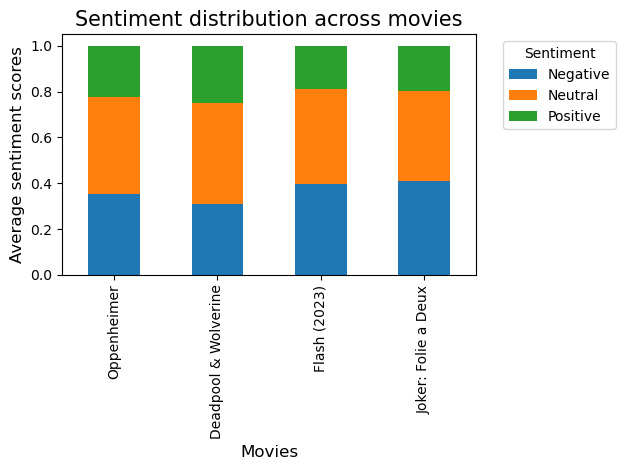

In [55]:
plot_sentiment_comparison(movies_data)

<Figure size 1400x700 with 0 Axes>

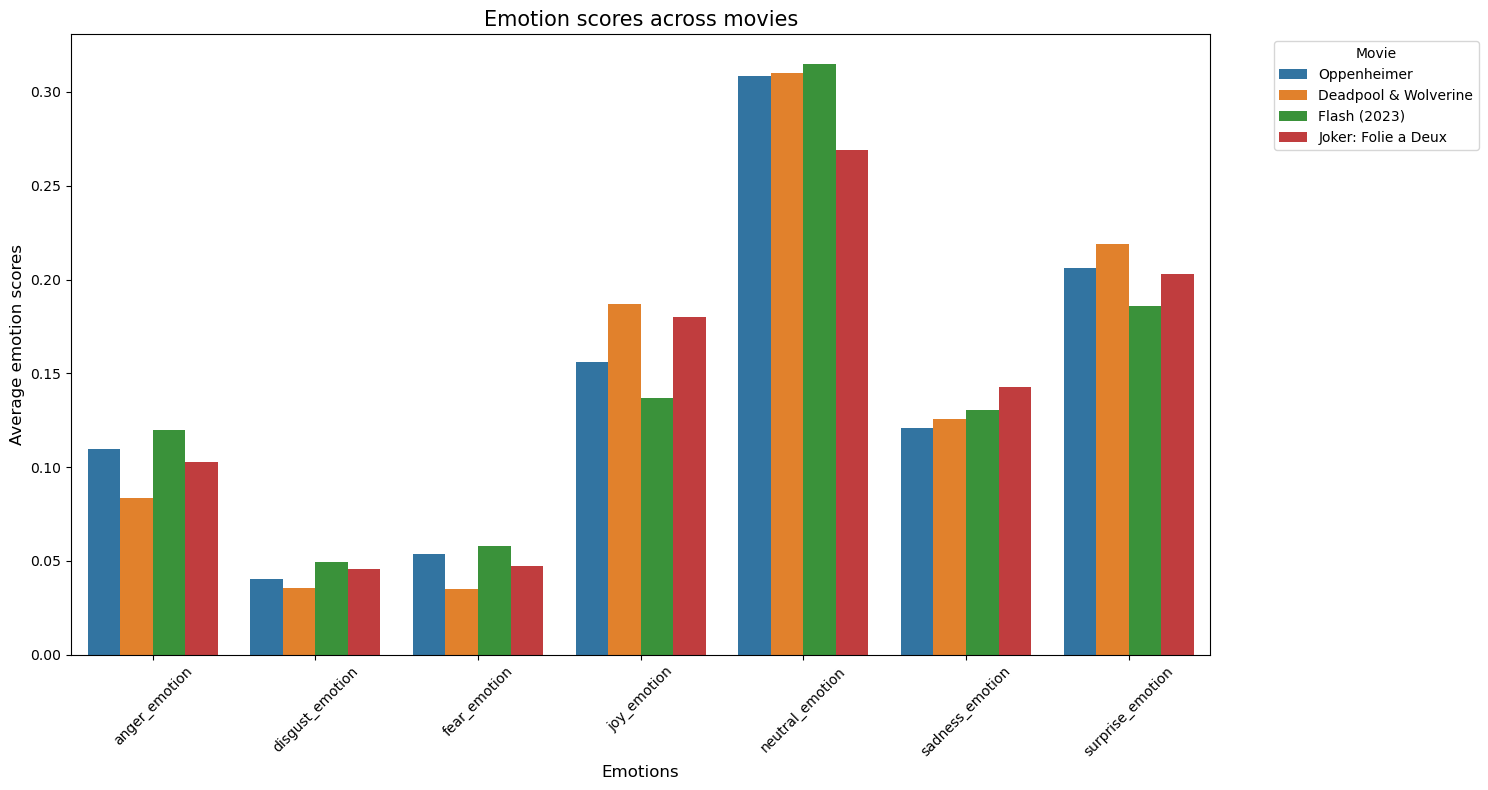

In [59]:
plot_emotion_comparison(movies_data)

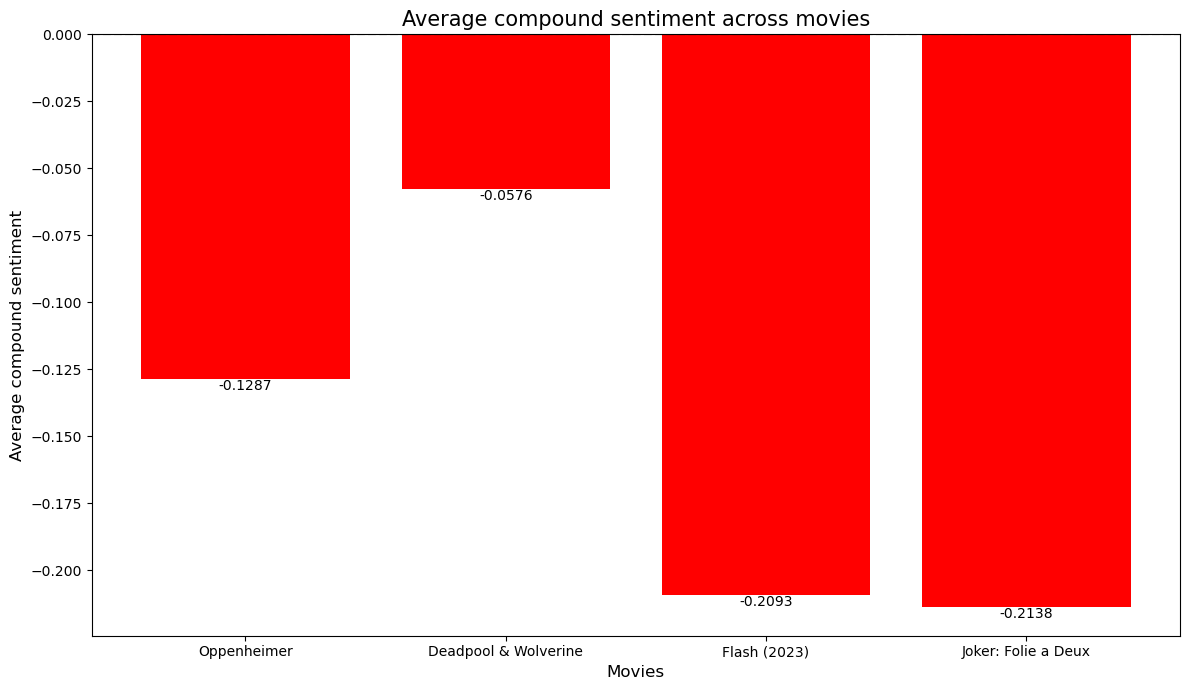

In [57]:
compound_sentiments = analyze_compound_sentiment(movies_data)